In [8]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

In [9]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [10]:
epochs = 5
batch_size = 64

In [11]:
trainloader, trainset, testloader, testset = getData('FashionMNIST', batch_size=batch_size)

In [12]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

            loss = optimizer.step(closure)

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
            model.losses.append(loss.item())

    print("Training complete.")
    return model

In [13]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [ ]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

AdaIPS_S (
Parameter Group 0
    T0: 4687.5
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.2780327796936035


In [ ]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=5)

IPS (
Parameter Group 0
    T: 4687.5
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.331430673599243
Epoch 1, Step 100, Loss: 0.8359425067901611
Epoch 1, Step 200, Loss: 0.7421186566352844
Epoch 1, Step 300, Loss: 0.7279670238494873
Epoch 1, Step 400, Loss: 0.6664255857467651
Epoch 1, Step 500, Loss: 0.7669581174850464
Epoch 1, Step 600, Loss: 0.5987370014190674
Epoch 1, Step 700, Loss: 0.460971862077713
Epoch 1, Step 800, Loss: 0.5692813396453857
Epoch 1, Step 900, Loss: 0.575652539730072
Epoch 2, Step 0, Loss: 0.6303300857543945
Epoch 2, Step 100, Loss: 0.5364619493484497
Epoch 2, Step 200, Loss: 0.5755197405815125
Epoch 2, Step 300, Loss: 0.6014038324356079
Epoch 2, Step 400, Loss: 0.39274755120277405
Epoch 2, Step 500, Loss: 0.5401445031166077
Epoch 2, Step 600, Loss: 0.7214139103889465
Epoch 2, Step 700, Loss: 0.6237825751304626
Epoch 2, Step 800, Loss: 0.4966868758201599
Epoch 2, Step 900, Loss: 0.5190115571022034
Epoch 3, Step 0, Loss: 0.4177539348602295
Epoch 3, Step 100, Loss: 

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3199522495269775
Epoch 1, Step 100, Loss: 0.5196670293807983
Epoch 1, Step 200, Loss: 0.5832023024559021
Epoch 1, Step 300, Loss: 0.6022454500198364
Epoch 1, Step 400, Loss: 0.5611456632614136
Epoch 1, Step 500, Loss: 0.4086129665374756
Epoch 1, Step 600, Loss: 0.2758854627609253
Epoch 1, Step 700, Loss: 0.5572483539581299
Epoch 1, Step 800, Loss: 0.4185510277748108
Epoch 1, Step 900, Loss: 0.4174169600009918
Epoch 2, Step 0, Loss: 0.4804537296295166
Epoch 2, Step 100, Loss: 0.3042009770870209
Epoch 2, Step 200, Loss: 0.3747647702693939
Epoch 2, Step 300, Loss: 0.41325950622558594
Epoch 2, Step 400, Loss: 0.24284957349300385
Epoch 2, Step 500, Loss: 0.3668532073497772
Epoch 2, Step 600, Loss: 0.42289942502975464
Epoch 2, Step 700, Loss: 0.34060

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
test(adaIpsModel)
test(ipsModel)
test(adamModel)

0.858
0.8202
0.8719


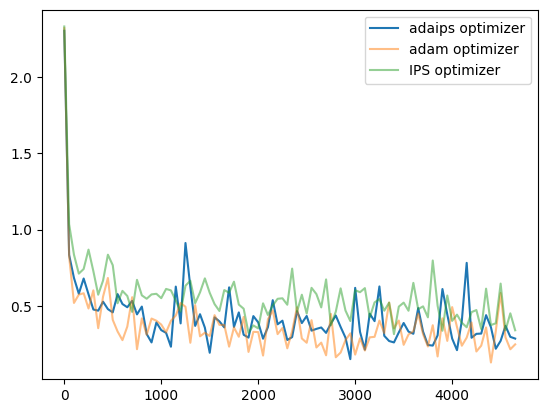

In [ ]:
models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (ipsModel, 'IPS optimizer')
]
exclude = []
focus = [adaIpsModel]
interval = 50
for model in models:
    if model[0] in exclude: continue
    plt.plot(
        [i for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model[0].losses) if i % interval == 0], 
        label=model[1],
        alpha=0.5 if model[0] not in focus else 1
    )

plt.legend()
plt.show()

In [ ]:
len(trainset) / batch_size

937.5